In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
warnings.filterwarnings('ignore')
from math import log

In [3]:
def searchBestCValue(solver, penalty, X_train, y_train, X_val, y_val, min, max, step):
    val_scores = []
    train_scores = []
    values = []
    for C in np.arange(min, max, step):
        model = LogisticRegression(random_state=None, solver=solver, penalty=penalty, C=C).fit(X_train, y_train)
        score = model.score(X_val, y_val)
        val_scores.append(score)
        score = model.score(X_train, y_train)
        train_scores.append(score)
        values.append(C)
    return val_scores, train_scores, values


# Dane wypełnione medianami

## Wczytanie danych

In [8]:
data = pd.read_csv("data/imputated_data.csv")
data = data.drop(['Imputated'], axis=1)
data = data.drop(['Unnamed: 0'], axis=1)

## Dodanie dodatkowych cech

Funkcje interakcji najlepiej sprawdzają się w przypadku cech, które na wykresie cecha1(cecha2) układają się mniej więcej wzdłuż funkcji x=y oraz wraz z x rośnie prawdopodobieństwo wystąpienia pozytywnej decyzji. Z pomocą wykresów korelacji znalazłem jeden taki przypadek: Glucose oraz BMI.

In [57]:
data['InsulinSquared'] = data['Insulin'].apply(lambda x: x**2)
data['GlucoseSquared'] = data['Glucose'].apply(lambda x: x**2)
data['InsulinGlucose'] = data['Insulin'] * data['Glucose']
data['BMISquared'] = data['BMI'].apply(lambda x:(x**2))
data['GlucoseBMI'] = data['Glucose'] * data['BMI']
data['InsulinLog'] = data['Insulin'].apply(lambda x: log(x))

## Podział danych

In [58]:
def splitDataset(X, y, random_state=0):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=0)
    return X_train, y_train, X_test, y_test, X_val, y_val

In [59]:
y = data['Outcome']
X = data.drop(["Outcome"], axis=1)

In [60]:
X_train, y_train, X_test, y_test, X_val, y_val = splitDataset(X, y, 0)

## Dobór parametrów

In [61]:
def testModelParameters(solver, penalty, X_train, y_train, X_val, y_val, plot=True, print_result=True):
    val_scores, train_scores, values = searchBestCValue('liblinear', 'l1', X_train, y_train, X_val, y_val, 0.1, 2, 0.01)
    if (plot):
        plt.figure()
        plt.plot(values, val_scores)
        plt.plot(values, train_scores)
        plt.show()
    max = np.max(val_scores)
    idx = val_scores.index(max)
    C = values[idx]
    if(print_result):
        print("Największa skutecznośc na zbiorze walidacyjnym: %.4f \ndla współczynnika C = %.4f" %(max, C))
    return solver, penalty, C, max

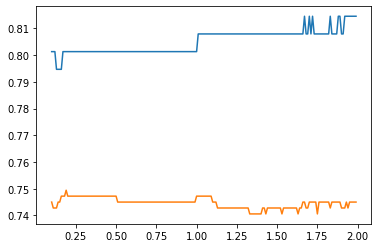

Największa skutecznośc na zbiorze walidacyjnym: 0.8146 
dla współczynnika C = 1.6700


In [23]:
solver, penalty, C, max = testModelParameters('liblinear','l1', X_train, y_train, X_val, y_val)

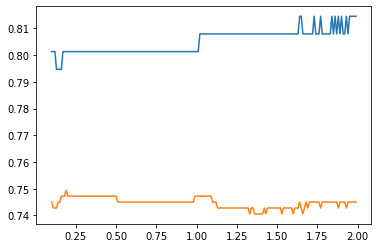

Największa skutecznośc na zbiorze walidacyjnym: 0.8146 
dla współczynnika C = 1.6400


In [24]:
solver, penalty, C, max = testModelParameters('liblinear','l2', X_train, y_train, X_val, y_val)

In [67]:
features = X.columns.values.tolist()
result_features = []
max_score = 0
max_score_features = []
model = LogisticRegression(random_state=None, solver='liblinear', penalty='l1', C=1.64)
for n in range(0,len(features)):
    tmp_max_score = 0
    tmp_test_score = 0
    best_features = []
    for i,val in enumerate(features):
        tmp_features = result_features.copy()
        tmp_features.append(val)
        score = cross_val_score(model, X_train[tmp_features], y_train)
        score = np.abs(score).mean()
        fitted_model = model.fit(X_train[tmp_features], y_train)
        test_score = fitted_model.score(X_test[tmp_features], y_test)
        #print(str(tmp_features) + " : " + str(score))
        if( score > tmp_max_score ):
            tmp_max_score = score
            best_features = tmp_features
            tmp_test_score = test_score
        if( score > max_score):
            max_score = score
            max_score_features = tmp_features
    result_features = best_features
    print("Dla tego etapu najlepszy wynik wynosi cv_score: %.4f , test_score: %.4f dla zbioru cech:\n%s" % (tmp_max_score, tmp_test_score, str(best_features)))
    features.remove(best_features[len(best_features)-1])
print(result_features)
print(max_score)
print(max_score_features)

Dla tego etapu najlepszy wynik wynosi cv_score: 0.7537 , test_score: 0.7467 dla zbioru cech:
['GlucoseBMI']
Dla tego etapu najlepszy wynik wynosi cv_score: 0.7515 , test_score: 0.7467 dla zbioru cech:
['GlucoseBMI', 'BloodPressure']
Dla tego etapu najlepszy wynik wynosi cv_score: 0.7537 , test_score: 0.7467 dla zbioru cech:
['GlucoseBMI', 'BloodPressure', 'SkinThickness']
Dla tego etapu najlepszy wynik wynosi cv_score: 0.7515 , test_score: 0.7667 dla zbioru cech:
['GlucoseBMI', 'BloodPressure', 'SkinThickness', 'BMI']
Dla tego etapu najlepszy wynik wynosi cv_score: 0.7515 , test_score: 0.7533 dla zbioru cech:
['GlucoseBMI', 'BloodPressure', 'SkinThickness', 'BMI', 'GlucoseSquared']
Dla tego etapu najlepszy wynik wynosi cv_score: 0.7472 , test_score: 0.7867 dla zbioru cech:
['GlucoseBMI', 'BloodPressure', 'SkinThickness', 'BMI', 'GlucoseSquared', 'Pregnancies']
Dla tego etapu najlepszy wynik wynosi cv_score: 0.7427 , test_score: 0.7867 dla zbioru cech:
['GlucoseBMI', 'BloodPressure', 'S

In [54]:
model = LogisticRegression(solver='liblinear', penalty='l1', C=1.64).fit(X_train[['GlucoseBMI','DiabetesPedigreeFunction']], y_train)
score = cross_val_score(model, X_train, y_train, cv=10)
avg_score = np.abs(score).mean()
print(score)
print(avg_score)
model.coef_

[0.80434783 0.75555556 0.73333333 0.62222222 0.8        0.73333333
 0.73333333 0.62222222 0.77777778 0.68888889]
0.7271014492753624


array([[0.00085377, 0.21068226]])

In [33]:
model = LogisticRegression(random_state=None, solver='liblinear', penalty='l1', C=1.64).fit(X_train, y_train)
score = cross_val_score(model, X_train, y_train)
avg_score = np.abs(score).mean()
print(score)
print(avg_score)
model.coef_

[0.79120879 0.66666667 0.76666667 0.67777778 0.73333333]
0.7271306471306472


array([[ 1.20879065e-01,  3.04775990e-02, -1.53268620e-02,
        -2.51776486e-03, -9.51054680e-03,  0.00000000e+00,
         3.03496080e-01,  1.41600935e-02, -8.69703874e-06,
        -1.42046078e-04,  7.40911263e-05, -7.96336899e-04,
         1.16124714e-03]])

In [44]:
values = []
max_values = []
for i in range(10):
    print(i)
    X_train, y_train, X_test, y_test, X_val, y_val = splitDataset(X, y, random_state=i)
    solver, penalty, C, max = testModelParameters('liblinear','l2', X_train, y_train, X_val, y_val, plot=False, print=False)
    values.append(C)
    max_values.append(max)
print(values)
print(max_values)
    

0
1
2
3
4
5
6
7
8
9
[1.4499999999999995, 1.4399999999999995, 1.4899999999999993, 1.4899999999999993, 1.4599999999999995, 1.4499999999999995, 1.4799999999999993, 1.4699999999999993, 1.4899999999999993, 1.4499999999999995]
[0.8145695364238411, 0.8145695364238411, 0.8145695364238411, 0.8145695364238411, 0.8145695364238411, 0.8145695364238411, 0.8145695364238411, 0.8145695364238411, 0.8145695364238411, 0.8145695364238411]


In [35]:

model = LogisticRegression(random_state=None, solver='liblinear', penalty='l1', C=1.49).fit(X_train, y_train)
scores = cross_val_score(model, X, y, cv=5 )
print(scores)
print(model.coef_)

[0.7615894  0.74834437 0.76       0.78666667 0.77333333]
[[ 1.22858438e-01  7.52431789e-02 -1.43070719e-02 -2.80329383e-03
  -1.24195789e-02  8.60426555e-02  3.46797701e-01  1.05454765e-02
  -9.07960153e-06 -1.71996077e-04  9.62394085e-05]]


In [36]:

scores = cross_val_score(model, X, y, cv=5)
scores

array([0.7615894 , 0.74834437, 0.76      , 0.78666667, 0.77333333])